In [1]:
!pip install -qU \
  langchain-core \
  langchain-google-genai \
  langchain-community \
  langgraph

%load_ext autoreload
%autoreload 2

In [2]:
from config import set_environment

set_environment("GOOGLE_API_KEY")

GOOGLE_API_KEY:  ········


In [30]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.0) 

In [4]:
job_description : str = """
A Java Developer designs, develops, tests, and maintains Java-based applications, ensuring high performance, scalability, and security. Responsibilities include writing clean code, collaborating with cross-functional teams, troubleshooting issues, integrating with databases and APIs, and documenting technical processes. Key requirements are strong Java and framework (e.g., Spring, Hibernate) proficiency, database skills, and experience with version control (e.g., Git). 
Key Responsibilities
Design and Development: Create and implement robust, high-volume, and low-latency Java applications. 
Code Quality: Write clean, efficient, testable, and scalable code following best practices. 
Requirement Analysis: Analyze user requirements and define system objectives and functionality. 
Integration: Integrate applications with databases and third-party services using APIs. 
Testing & Debugging: Conduct thorough testing, debug complex issues, and resolve application problems. 
Deployment: Participate in the full software development lifecycle, including deployment and maintenance. 
Documentation: Prepare detailed documentation for application designs, technical specifications, and user support. 
Team Collaboration: Work with cross-functional teams, such as designers, product owners, and other engineers, to deliver applications. 

"""


In [5]:
prompt_template_enum = (
    """
    Given a job description, decide whether it suits a junior Java
    developer.
    Job Description:

    {job_description}

    Answer only YES or NO
    """
)



In [6]:
from enum import Enum

from langchain.output_parsers import EnumOutputParser
from langchain_core.messages import HumanMessage

In [7]:
class IsSuitableJobEnum(Enum):
    YES = "YES"
    NO = "NO"

parser = EnumOutputParser(enum=IsSuitableJobEnum)

assert parser.invoke("NO") == IsSuitableJobEnum.NO
assert parser.invoke("YES\n") == IsSuitableJobEnum.YES
assert parser.invoke("YES \n") == IsSuitableJobEnum.YES


In [33]:
chain = llm | parser

result = chain.invoke(prompt_template_enum.format(job_description = job_description))

print(result)

IsSuitableJobEnum.YES


In [43]:
from langchain_core.language_models import GenericFakeChatModel

from langchain_core.messages import AIMessage

class MessageIterator:

    def __init__(self):
        self.count = 0

    def __iter__(self):
        return self

    def __next__(self):
        print("calling_next")
        self.count += 1
        if self.count % 2 == 1:
            raise ValueError("Something went wrong")
        return AIMessage(content=f"YES")


fake_llm = GenericFakeChatModel(messages = MessageIterator())


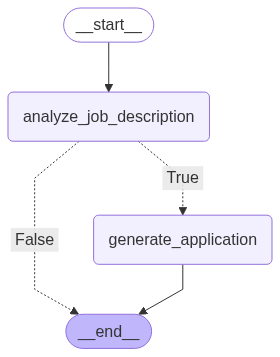

In [38]:
from typing_extensions import TypedDict
from langchain_core.runnables.config import RunnableConfig
from langgraph.graph import StateGraph, START, END
import logging


logger = logging.getLogger(__name__)

class JobApplicationState(TypedDict):
    job_description: str
    is_suitable: IsSuitableJobEnum
    application: str

llms = {
    "fake": fake_llm,
    "Google": llm
}
    
def analyze_job_description(state, config: RunnableConfig):
    try:
        model_provider = config["configurable"].get("model_provider", "Google")
        llm_selected = llms[model_provider]
        analyze_chain = llm_selected | parser
        prompt = prompt_template_enum.format(job_description = state["job_description"])
        result = analyze_chain.invoke(prompt)
        return {
            "is_suitable": result
        }
    except Exception as e:
        logger.error(f"Exception {e} occured while executing analyze_job_description")
        return {
            "is_suitable": IsSuitableJobEnum.NO
        }


 

def is_suitable_condition(state):
    return state["is_suitable"] == IsSuitableJobEnum.YES

def generate_application(state):
    print("...generating application...")
    return {"application": "some_fake_application", "actions": ["action2"]}
    
builder = StateGraph(JobApplicationState)

builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)

builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges(
    "analyze_job_description", is_suitable_condition,
    {
        True: "generate_application",
        False: END
    }
)

builder.add_edge("generate_application", END)
graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))



In [40]:
graph.invoke({"job_description":"fake_jd"}, config={"configurable":
{"model_provider": "fake"}})

...generating application...


{'job_description': 'fake_jd',
 'is_suitable': <IsSuitableJobEnum.YES: 'YES'>,
 'application': 'some_fake_application'}

In [44]:
fake_llm_retry = fake_llm.with_retry(
    retry_if_exception_type=(ValueError,),
    wait_exponential_jitter = True,
    stop_after_attempt=2    
)

chain = fake_llm_retry | parser

result = chain.invoke(prompt_template_enum.format(job_description = job_description))

print(result)

calling_next
calling_next
IsSuitableJobEnum.YES
